# White Box Attacks

This notebook provides a beginner friendly introduction to using adversarial attacks on image classification as part of Test & Evaluation of a small benchmark dataset based on overhead imagery. The first attack we will use is Projected Gradient Descent (PGD), a simple attack based on the model gradients warranted the input. We then visualize the attack and afterwards constrain the change applied to the image to a fraction of the input image using a patch attack. Computing the performance under these white-box attacks is a crucial step in T&E. 

__Intended Audience__: All T&E users 

__Requirements__: Basic Python and Torchvision / ML skills. 

__Time Required__: Full run of the notebook: <10 minutes

### Contents
1. Imports and set-up
2. Load Drone data and model for classification
3. Define and run PGD attack
4. Patch Attacks
5. Targeted White-box attack
5. Conclusion
6. Next steps

### Take-aways 
- how to define a custom model and use the drone imagery
- how to run an attack with JATIC
- how to inspect images and understand whether they fool the model
- How white box attacks (PGD, Patch attacks) work

## 1. Imports and Set-up

We import all necessary libraries for this tutorial. In this order, we first import general libraries such as numpy, then load relevant methods from ART. We then load the corresponding HEART functionality and specific torch functions to support the model. Lastly, we use a command to plot within the notebook.

In [1]:
import numpy as np
import os
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt

#ART imports
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from art.attacks.evasion import AdversarialPatchPyTorch

#HEART imports
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier
from heart_library.metrics import AccuracyPerturbationMetric
from heart_library.attacks.attack import JaticAttack
from heart_library.metrics import HeartAccuracyMetric

#torchvision imports
import torchvision
from torchvision import transforms

%matplotlib inline


## 2. Load Drone data and model for classification

We load the data, importing only a small part to save compute for this small demonstration. We then define the model and wrap it as JATIC pytorch classifier.

The data can be replaced as desired by the user - we first define the six labels, specify the subset used in this notebook (10 images), specify a consistent size and upscale the data to 224 x 224 pixels and then wrap everything as a modified dataframe.

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

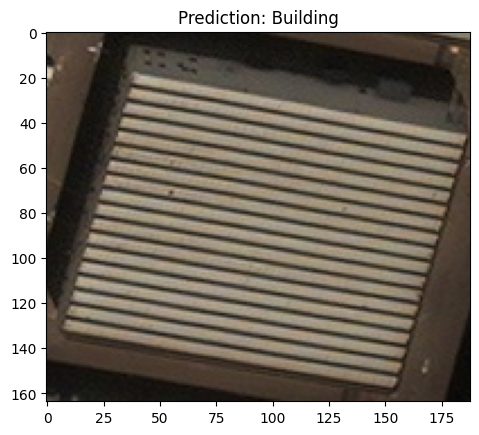

In [2]:
classes = {
    0:'Building',
    1:'Construction Site',
    2:'Engineering Vehicle',
    3:'Fishing Vessel',
    4:'Oil Tanker',
    5:'Vehicle Lot'
}

data = load_dataset("CDAO/xview-subset-classification", split="test[0:10]")
idx = 3
plt.title(f"Prediction: {classes[data[idx]['label']]}")
plt.imshow(data[idx]['image'])

'''
Transform dataset
'''
IMAGE_H, IMAGE_W = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((IMAGE_H, IMAGE_W)),
    transforms.ToTensor()
])
dataT = data.map(lambda x: {"image": preprocess(x["image"]), "label": x["label"]})
to_image = lambda x: transforms.ToPILImage()(torch.Tensor(x))

sample_data = torch.utils.data.Subset(dataT, range(10))

We then load a custom model which comes with the repository. Most important is that the model has the correct input shape and is trained to perform decently well on the data. At the bottom, we wrap the model into a ```JaticPyTorchClassifier```.

/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


/root/miniforge3/envs/heart-env/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


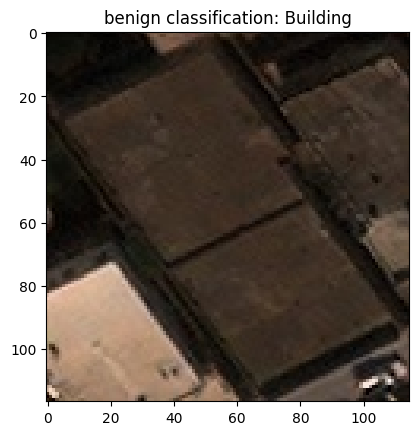

In [3]:
model = torchvision.models.resnet18(False)
num_ftrs = model.fc.in_features 
model.fc = torch.nn.Linear(num_ftrs, len(classes.keys())) 
model.load_state_dict(torch.load('../../../utils/resources/models/xview_model.pt'))
#_ = model.eval()

'''
Wrap the model
'''
jptc = JaticPyTorchClassifier(
    model=model, loss = torch.nn.CrossEntropyLoss(), input_shape=(3, 224, 224),
    nb_classes=len(classes), clip_values=(0, 1)
)

#plot original image
pred_batch = jptc(sample_data)
plt.imshow(data[0]['image'])
_ = plt.title(f'benign classification: {classes[np.argmax(np.stack(pred_batch[0]))]}')
plt.show()

## 3. Define and run PGD attack

We are now ready to define the first attack, Projected Gradient Descent (PGD). We then apply the attack to the first image in our test data, applying many iterations to ensure that the images fool the classifier. We first plot the result and then compute the benign and adversarial performance on a larger batch. From there we observe that while the initial performance is correct, the final classification is wrong (however we are computing the metric only on one sample).

When rerunning this notebook, this part can be counted as completed if a correctly classified sample is misclassified.

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

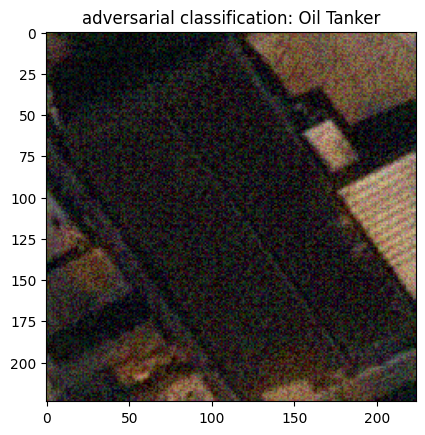

In [4]:
#define attack
pgd_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=100, eps=0.1, eps_step=0.1, targeted=False)

#wrap and run attack
jattack = JaticAttack(pgd_attack, norm=2)
x_adv, y, metadata = jattack(data=sample_data)

#plot adversarial counterpart of image above
pred_batch = jptc(x_adv)
plt.imshow(x_adv[1].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {classes[np.argmax(pred_batch,axis=1)[1]]}')
plt.show()

In [5]:
#using the adversarial examples from above, computing performance metric
groundtruth_target_batch = data['label'][0:10]
benign_preds_batch = jptc(sample_data)
adversarial_preds_batch = jptc(x_adv)

metric = AccuracyPerturbationMetric(benign_preds_batch, metadata)
metric.update(adversarial_preds_batch, groundtruth_target_batch)
print(metric.compute())

{'clean_accuracy': 0.8, 'robust_accuracy': 0.0, 'mean_delta': 33.070686}


## 4. Patch Attacks

PGD applies perturbations to the entire image. This is not necessarily desired, so next we use an attack that applies a local perturbation, or a patch, to the image. Analogous to before, we define attack parameters (including patch size and placement) and optimize the patch. We first plot the patch by itself, before visualizing it on different samples. This visualization shows us that the patch is not effective on all samples.

When rerunning this notebook, this part can be counted as completed if a correctly classified sample is misclassified.

Adversarial Patch PyTorch:   0%|          | 0/700 [00:00<?, ?it/s]

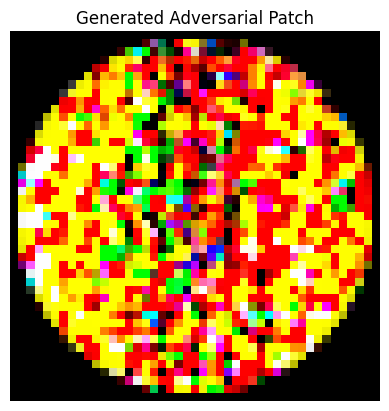

-------------


In [6]:
batch_size = 16
scale_min = 0.3
scale_max = 1.0
rotation_max = 0
learning_rate = 0.001 #500
max_iter = 700
patch_shape = (3, 45, 45)
patch_location = (0,0)

ap = JaticAttack(AdversarialPatchPyTorch(estimator=jptc, rotation_max=rotation_max, patch_location=patch_location,
                      scale_min=scale_min, scale_max=scale_max, patch_type='circle',
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=patch_shape, verbose=True, targeted=False))

patched_images, _, metadata = ap(data=sample_data)
patch = metadata[0]["patch"]
patch_mask = metadata[0]["mask"]

#plot patch
plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
_ = plt.title('Generated Adversarial Patch')
plt.show()
print('-------------')

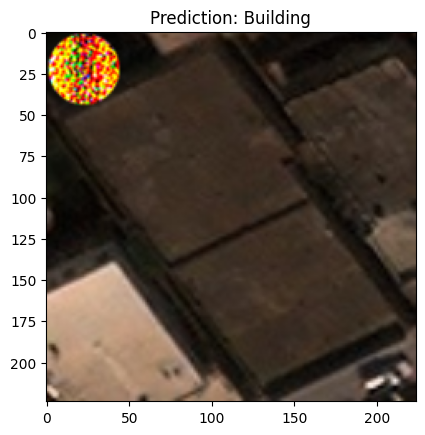

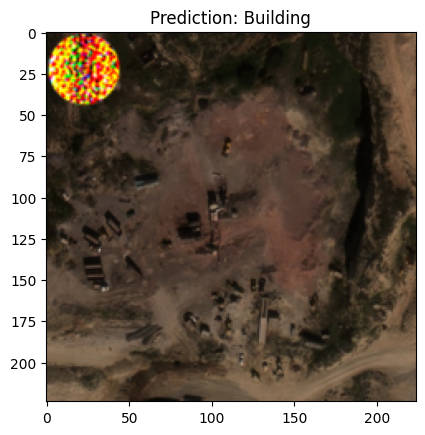

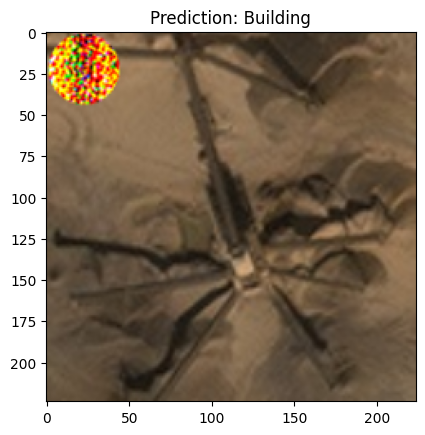

In [ ]:
#plot the images with the patch applied and prediction
preds = jptc(patched_images)
for i, patched_image in enumerate(patched_images[0:1]):
    _ = plt.title(f'''Prediction: {classes[np.argmax(preds[i])]}''')
    plt.imshow(patched_image.transpose(1,2,0))
    plt.show()
for i, patched_image in enumerate(patched_images[7:9]):
    _ = plt.title(f'''Prediction: {classes[np.argmax(preds[i])]}''')
    plt.imshow(patched_image.transpose(1,2,0))
    plt.show()

While we see that the patch does not work for images of the class 'building', it turns the outputs of other classes' images into buildings.

## 5. Targeted White-box Attack

The following cells demonstrate execution of a targeted PGD attack against the model. Unlike an untargeted attack, in this scenario and adversary is attempting to elicit a specific incorrect classification from the model. For instance, the following examples demonstrates how an attack might trick a classifier to misclassify a building as an oil tanker. In order to achieve this, we simply provide an incorrect _target_ label in the dataset we pass to the attack augmentation and set the _targeted_ parameter to be _True_. 

It can sometimes be easier to successfully attack a model using a targeted attack as, with a well defined objective, the attack may converge quicker (and with few necessary iterations).


Here we set the target label to be _4_ in all instances of our sample data. An index of _4_ corresponds to the class "Oil Tanker".

In [25]:
class TargetedImageDataset:
    
    def __init__(self, images):
        self.images = images
    def __len__(self)->int:
        return len(self.images)
    def __getitem__(self, ind: int):
        image = np.asarray(self.images[ind]['image'])
        return image, 4, {}

targeted_sample_data = TargetedImageDataset(sample_data)

The only other step is to add the _targeted_ parameter and set it to _True_. This tells the PGD algorithm to minimize the loss between the models prediction and the provided target label, in this case "Oil Tanker".

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

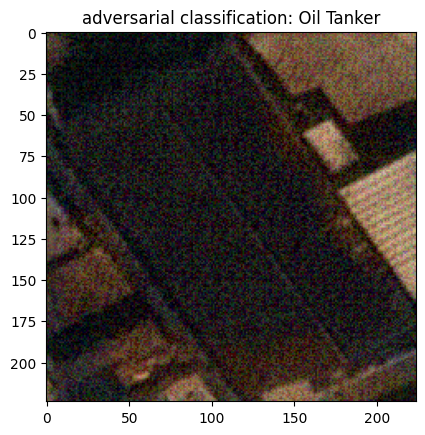

In [26]:
#define attack
pgd_attack = ProjectedGradientDescentPyTorch(estimator=jptc, max_iter=100, eps=0.1, eps_step=0.1, targeted=True)

#wrap and run attack
jattack = JaticAttack(pgd_attack, norm=2)
x_adv, y, metadata = jattack(data=targeted_sample_data)

#plot adversarial counterpart of image above
pred_batch = jptc(x_adv)
plt.imshow(x_adv[1].transpose(1,2,0))
_ = plt.title(f'adversarial classification: {classes[np.argmax(pred_batch,axis=1)[1]]}')
plt.show()

## 6. Conclusion
We have successfully attacked a model with adversarial example that are based on the model's gradients. In the next steps, we can attempt to defend the computed examples or decrease the knowledge the attacker has by running black box attacks which are not based on the model's gradients.

## 7. Next steps
- [2. How to Simulate Black-box Attacks for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/2_How_to_Simulate_Black-Box_Attacks_for_Image_Classification.ipynb)
- [3. How to Simulate Auto Attack for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/3_How_to_Simulate_Auto_Attack_for_Image_Classification.ipynb)
- [4. How to Create Defenses for Image Classification](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/4_How_to_Create_Defenses_for_Image_Classification.ipynb)
- [5. How to Replace Datasets in Model Evaluation](https://github.com/IBM/heart-library/tree/main/notebooks/how_tos/image_classification/5_How_to_Replace_Datasets_in_Model_Evaluation.ipynb)